# Positioning With Doppler Observables

In [1]:
# Section 1 - Imports

import datetime
import attotime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
from os.path import join

from dsoclasses.doris.algorithms import beacon_nominal_frequency, starec_pcv
from dsoclasses.rinex.doris.rinex import DorisRinex
from dsoclasses.time.pyattotime import at2pt, fsec2asec
from dsoclasses.orbits import sp3c, interpolator
from dsoclasses.geodesy import transformations
from dsoclasses.gnss import systems as gs
from dsoclasses.gnss import algorithms as alg
from dsoclasses.troposphere.vmf3 import SiteVmf3
from dsoclasses.sinex import sinex

# Section 1.2 – Define File Paths
data_path = "/home/xanthos/Software/AcademicSoftware/data"
drinex = join(data_path, "s6arx24001.001")
dpod = join(data_path, "dpod2020_041.snx")
dpod_freq_corr = join(data_path, "dpod2020_041_freq_corr.txt")
dsp3 = join(data_path, "ssas6a20.b23357.e24001.DG_.sp3.001")
vmf3_data = join(data_path, "y2024.vmf3_d")

# Section 1.3 - Load Sp3 + Initialize Interpolator 
intrp = interpolator.Sp3Interpolator.from_sp3(dsp3, ['L'], interval_in_sec=310, min_data_pts=10, itype='Barycentric')
# the sp3 only holds one satellite, let's get its id:
assert len(list(intrp._interpolators.keys())) == 1
sp3_id = list(intrp._interpolators.keys())[0]

# Section 1.4 - Intitialize DorisRinex and select a beacon (Dionysos/DIOB)
rnx = DorisRinex(drinex)

# Section 1.5 - Choose a station and get coordinates (DIOB DORIS beacon)
site_name = 'DIOB'
diob_crd = sinex.extract_sinex_coordinates(dpod, [site_name], rnx.time_first_obs, True)[site_name]
rsta = np.array([diob_crd['X'], diob_crd['Y'], diob_crd['Z']])
lat, lon, hgt = transformations.car2ell(*rsta)

# Section 1.6 - Initialize VMF3 for chosen site
vmf = SiteVmf3(vmf3_data, [site_name])

In [2]:
def sat_at_emission_time(
    rsta, t_reception, sp3_interpolator, sat, tolerance=(1e-3, 1e-3, 1e-3)
):
    """Compute and return the satellite position at signal emission time.
    
    Parameters:
    rsta : Coordinates of observing station (ECEF, cartesian) in [m]
    t_reception: Time of reception, e.g. as recorded in RINEX
    interpolator: An Sp3Interpolator instance, where we can query sat's
           coordinates.
    sat: The satellite's id, as in the interpolator (e.g. 'G03').
    tolerance: An array, or list of max discrepancies untill we consider
         successeful convergence. These are actually maximum allowed
         coordinate discrepancies (in [m]).
         
    Returns:
    x, y, z, c, dt
        where x, y, z, are the (ECEF, cartesian) coordinates of the
    satellite at emission time; c is the satellite's clock correction at
    the same epoch. dt is t_reception - t_emission in fractional seconds.
    """
    MAX_ITERATIONS = 10
    # starting t_(emission) is t_(reception)
    t_emission = t_reception
    # get satellite coordinates at t, using the interpolator
    x, y, z, c = sp3_interpolator.sat_at(sat, t_emission)

    count_it = 0
    while count_it < MAX_ITERATIONS:
        # iterate while the is no 'significant' change in sat coordinates
        r = np.linalg.norm(np.array([x,y,z]) - np.array(rsta))
        dt = r / C
        t_emission = t_reception - fsec2asec(dt)
        xnew, ynew, znew, clk = sp3_interpolator.sat_at(sat, t_emission)
        if np.any(np.greater_equal(
                np.abs(np.array((xnew, ynew, znew)) - np.array((x, y, z))),
                np.array(tolerance),
            )):
            x = xnew
            y = ynew
            z = znew
            count_it += 1
        else:
            return xnew, ynew, znew, clk, dt
    raise RuntimeError(f"[ERROR] Failed finding emission time for sat {sat}")

In [15]:
# globals
CUTOFF_ANGLE = np.radians(10) # cut-off angle at 10 [deg]
C = 299792458e0 # speed of light in vacum, [m/sec]

# nominal transmitting frequencies for DIOB
s1, u2 = beacon_nominal_frequency(rnx.kfactor(site_name))
sqrt_gamma = s1 / u2
gamma = sqrt_gamma * sqrt_gamma
# Correct equivalent IF frequency
feN = frN = (gamma * s1 - u2) / (gamma - 1.0)
def iflc(L2ghz, L400mhz):  # IF phase in cycles (same units as inputs)
    return (gamma * L2ghz - L400mhz) / (gamma - 1.0)
print(f'Nominal frequencies S1={s1*1e-6:.1f}GHz (or {C/s1:.3f} m.), U2={u2*1e-3:.1f}MHz (or {C/u2:.3f} m.)')
print(f'Iono-Free LC frequency L3={feN*1e-6:.1f}GHz or {C/feN:.3f} m.')
assert feN == frN

# Apply PCO corrections for the L_IF lin. combination
r_2GHz = np.array([0e0, 0e0, 487e-3])
r_400MHz = np.array([0e0, 0e0, 0e0])
rsta = rsta + transformations.geodetic2lvlh(lat, lon) @ (gamma*r_2GHz - r_400MHz) / (gamma-1.)

# Initialize variables for looping
# --------------------------------
last_tai   = None   # previous (to current) observation epoch in TAI
raw_doppler = []    # Doppler observations collected
pass_nr = 0         # satellite pass number

# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon == rnx.name2id(site_name):
            
            # use the block-provided clock correction to get to (approximate) TAI
            # date(TAI) = epoch + receiver clock offset
            tai = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset() * 1e9)

            # satellite position
            # satx, saty, satz, _, _ = sat_at_emission_time(rsta, tai, intrp, 'L40')
            satx, saty, satz, _, _ = alg.sat_at_emission_time(rsta, tai, intrp, 'L40')
            # satx, saty, satz, _ = intrp.sat_at('L40', tai)
            rsat = np.array([satx, saty, satz])

            # compute range, azimouth and elevation between site and satellite
            r, az, el = transformations.azele(rsat, rsta)

            # only consider observation if above cut-off angle
            if el < CUTOFF_ANGLE:
                continue

            # get the 2GHz Iono-Free observation
            L2ghz = data['L1']['value']
            L400mhz = data['L2']['value']
            cphase = iflc(L2ghz, L400mhz)

            # apply frequency offset - get true receiver frequency
            frT = frN * (1. + data['F']['value'] * 1e-11)

            # compute tropospheric delay at elevation
            dtropo = vmf.tropo_delay(site_name, lat, lon, el, at2pt(tai))

            # compute difference to previous obs, if any
            if last_tai is not None and (tai - last_tai).total_seconds() <= 10.:
                # time diff from previous observation
                dt = float((tai-last_tai).total_nanoseconds()) * 1e-9
                assert dt != 0e0
                # observed range-rate
                rr_observed = -(C / feN) * (feN - frT - (cphase-last_cphase)/dt) - (dtropo-last_dtropo)/dt
                raw_doppler.append({
                    'rsat1': last_rsat,
                    'rsat2': rsat,
                    'el': last_el + (el-last_el)/2.,
                    'dt': dt,
                    'v_obs': rr_observed,
                    'dT': (dtropo-last_dtropo)/dt,
                    'Ndop': cphase-last_cphase,
                    'pass': pass_nr,
                    'frT': frT,
                    'epoch': tai
                })
                
            # is this a different pass ?
            elif last_tai is not None and (tai - last_tai).total_seconds() > 300.:
                pass_nr += 1
                pcvrsta = rsta
                # print(f'New pass #{pass_nr} at {at2pt(tai)}')
            else:
                pcvrsta = rsta

            # assign values for next computation
            last_tai = tai
            last_rsat = rsat
            last_el = el
            last_dtropo = dtropo
            last_cphase = cphase

print(f"Collected #{len(raw_doppler)} doppler obs, in {pass_nr+1} passes")

Nominal frequencies S1=2036.2GHz (or 0.147 m.), U2=401250.0MHz (or 0.747 m.)
Iono-Free LC frequency L3=2102.3GHz or 0.143 m.
Collected #878 doppler obs, in 6 passes


In [16]:
from collections import Counter
import bisect

def remove_minor_passes(raw_dop, min_obs_in_pass, renumber=True):
    """
    Filter out passes with too few observations. Optionally re-number the remaining passes.

    raw_dop: list[dict], each dict has a key 'pass_nr' (int)
    min_obs_in_pass: int, minimum observations required to keep a pass
    renumber: bool, if True make pass_nr contiguous after removals (0..N-1 in ascending order)
    """
    # 1) Count observations per pass
    counts = Counter(d['pass'] for d in raw_dop)
    print('Number of observations per pass:')
    for k,v in counts.items(): print(f'Pass Nr.: {k} # Obs. {v:4d}')

    # 2) Identify passes to remove
    to_remove = {pn for pn, c in counts.items() if c < min_obs_in_pass}
    if not to_remove:
        # Nothing to remove; optionally renumber and return
        print('All passes hold minimum number of observations; no pass to remove')
        kept = [d.copy() for d in raw_dop]
        if renumber:
            remaining = sorted({d['pass'] for d in kept})
            mapping = {old: new for new, old in enumerate(remaining)}
            for d in kept:
                d['pass'] = mapping[d['pass']]
        return kept
    else:
        print(f'Removing passes: {to_remove}')

    # 3) Keep only entries whose pass_nr is not removed
    kept = [d.copy() for d in raw_dop if d['pass'] not in to_remove]

    if not renumber:
        return kept

    # 4) Renumber: subtract how many removed pass numbers are < current pass_nr
    removed_sorted = sorted(to_remove)
    for d in kept:
        pn = d['pass']
        shift = bisect.bisect_left(removed_sorted, pn)
        d['pass'] = pn - shift
    return kept

raw_doppler = remove_minor_passes(raw_doppler, 70)
pass_nr = max({d['pass'] for d in raw_doppler}) + 1
print(f"Collected #{len(raw_doppler)} doppler obs, in {pass_nr} passes")

Number of observations per pass:
Pass Nr.: 0 # Obs.  141
Pass Nr.: 1 # Obs.  187
Pass Nr.: 2 # Obs.   89
Pass Nr.: 3 # Obs.  122
Pass Nr.: 4 # Obs.  189
Pass Nr.: 5 # Obs.  150
All passes hold minimum number of observations; no pass to remove
Collected #878 doppler obs, in 6 passes


In [27]:
# Section – Weighted Least Squares Solution
# --------------------------------------------

Np = (max(obs['pass'] for obs in raw_doppler) + 1)  # Number of passes

# Initial guess: [x, y, z, Δf_pass0, Δf_pass1, ...]
x0 = np.zeros(3 + Np) # parameter vector
x0[0:3] = rsta # start with nominal beacon position
        
x = x0.copy()

m = len(raw_doppler)       # number of valid Doppler observations
J = np.zeros((m, len(x0))) # Jacobian matrix (design matrix)
dl = np.zeros(m)           # residual vector (observed - modeled)

sigma0 = .1                # sigma 0 in [m/sec]
elvs = np.array([obs['el'] for obs in raw_doppler]) # elevations arrays
sigma_i = sigma0 / np.sin(elvs)                      # per-observation stdev
sqrt_w = 1.0 / sigma_i                               # = sqrt(w_i)
W = sqrt_w**2                                        # = 1/sigma_i^2

LS_ITERATIONS = 5 # number of least squares iterations

for ls_iteration in range(LS_ITERATIONS):
    J = np.zeros((m, len(x)))
    dl = np.zeros(m)
    for i, obs in enumerate(raw_doppler):

        rsat1 = obs['rsat1']
        rsat2 = obs['rsat2']
        dt    = obs['dt']
        v_obs = obs['v_obs']
        Ndop  = obs['Ndop']
        #frT   = obs['frT']

        # Current parameter estimates
        r_beacon = x[0:3]               # beacon position estimate
        pass_id  = obs['pass']
        df       = x[3 + pass_id]        # frequency bias

        # Computed range-rate
        r1 = np.linalg.norm(rsat1 - r_beacon)
        r2 = np.linalg.norm(rsat2 - r_beacon)
        v_comp = (r2 - r1) / dt - (C/feN) * (Ndop/dt+frT) * df

        # residual (observed - modeled), UNWEIGHTED
        dl[i] = v_obs + obs['dT'] - v_comp
        
        if abs(dl[i]) > 10.0:
            print(f"Skipping obs {i} due to large residual: {dl[i]:+.3f} m/s")
            sqrt_w[i] = 0.0
            continue

        # Jacobian Matrix
        J[i, 0:3] = ((r_beacon - rsat2) / r2 - (r_beacon - rsat1) / r1) / dt
        J[i, 3 + pass_id] = -(C/feN) * (Ndop/dt+frT)
        
    Jw  = J * sqrt_w[:, None]      # each row scaled by sqrt(w_i)
    dlw = dl * sqrt_w              # same scaling for rhs

    # least squares solution
    dx, *_ = np.linalg.lstsq(Jw, dlw, rcond=None)
    x += dx

    # postfit residuals
    postfit_w = dlw - Jw @ dx
    # convert to unweighted for thresholding
    postfit = np.divide(postfit_w, sqrt_w, out=np.zeros_like(postfit_w), where=sqrt_w!=0)

    # update sigma0_hat and 3σ rejection
    dof = int(np.count_nonzero(sqrt_w)) - len(x)
    dof = max(dof, 1)
    sigma_hat0 = np.sqrt((postfit_w @ postfit_w) / dof)
    print(f'Iteration {ls_iteration} sigma={sigma_hat0:.3f} dr=({dx[0]:+8.3f}, {dx[1]:+8.3f}, {dx[2]:+8.3f})')

    # standardized residuals: r_i / sigma_i   (sigma_i already per-obs stdev)
    z = np.divide(postfit, sigma_i, out=np.zeros_like(postfit), where=sigma_i>0)
    #print(z)
    #break

    n_rej = 0
    for i in range(m):
        if sqrt_w[i] > 0 and abs(z[i]) > 2.0:
            sqrt_w[i] = 0.0
            n_rej += 1

    if n_rej:
        print(f'Iter {ls_iteration}: rejected {n_rej} obs with |z|>3')

# de-weight residuals
dl_unweighted = np.divide(dlw, sqrt_w, out=np.zeros_like(dlw), where=sqrt_w!=0)

Iteration 0 sigma=0.103 dr=(  +5.391,   +0.319,   +3.063)
Iter 0: rejected 1 obs with |z|>3
Iteration 1 sigma=0.040 dr=(  -0.087,   +0.101,   -0.012)
Iteration 2 sigma=0.040 dr=(  -0.000,   +0.000,   -0.000)
Iteration 3 sigma=0.040 dr=(  +0.000,   +0.000,   +0.000)
Iteration 4 sigma=0.040 dr=(  +0.000,   -0.000,   -0.000)


In [28]:
print(f'Dr w.r.t. a-priori values: {rsta[0]-x[0]:+8.3f}, {rsta[1]-x[1]:+8.3f}, {rsta[2]-x[2]:+8.3f}')
print('Df\'s (per pass):')
for i in range(Np): print(f'#{i} dfreq = {x[3+i]:.1e}')

Dr w.r.t. a-priori values:   -5.304,   -0.420,   -3.051
Df's (per pass):
#0 dfreq = -9.8e-09
#1 dfreq = -9.8e-09
#2 dfreq = -9.8e-09
#3 dfreq = -9.8e-09
#4 dfreq = -9.8e-09
#5 dfreq = -9.8e-09


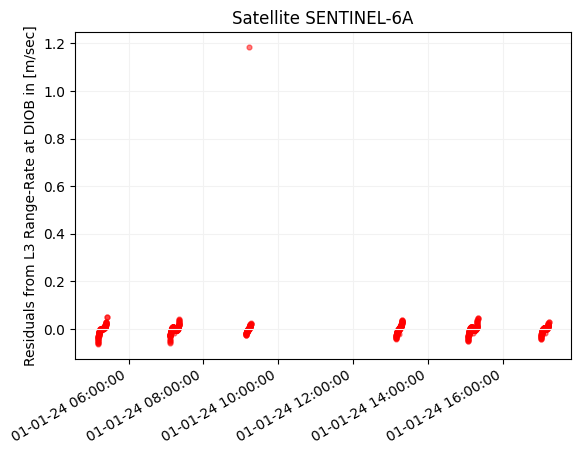

In [29]:
plt.scatter([at2pt(d['epoch']) for d in raw_doppler], dl, alpha=0.5, s=12, c='red')
plt.grid(color='0.95')
plt.ylabel(f"Residuals from L3 Range-Rate at {site_name} in [m/sec]")
plt.title(f"Satellite {rnx.sat_name}")
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
plt.gcf().autofmt_xdate()
plt.show()

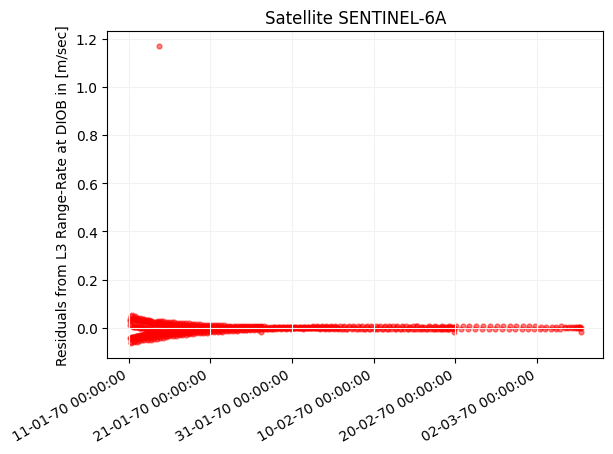

In [21]:
plt.scatter([np.degrees(d['el']) for d in raw_doppler], dl, alpha=0.5, s=12, c='red')
plt.grid(color='0.95')
plt.ylabel(f"Residuals from L3 Range-Rate at {site_name} in [m/sec]")
plt.title(f"Satellite {rnx.sat_name}")
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
plt.gcf().autofmt_xdate()
plt.show()